In [219]:
library(mclogit)
library(reshape)
library(rjags)
library(bayesplot)

In [7]:
candy <- read.csv("../data/candy.csv")

In [8]:
head(candy)

,id,Choice,Choose,Alt,Dark,Soft,Nuts
,<int>,<fct>,<int>,<int>,<int>,<int>,<int>
1,1,c1,0,1,0,0,0
2,1,c2,1,2,0,0,1
3,1,c3,0,3,0,1,0
4,1,c4,0,4,0,1,1
5,1,c5,0,5,1,0,0
6,1,c6,0,6,1,0,1


In [11]:
clogit_model <- mclogit(cbind(Choose, id) ~ Dark + Soft + Nuts, data=candy)


Iteration 1 - Deviance = 29.15514
Iteration 2 - Deviance = 28.73726
Iteration 3 - Deviance = 28.72701
Iteration 4 - Deviance = 28.72699
Iteration 5 - Deviance = 28.72699
converged


In [12]:
summary(clogit_model)


Call:
mclogit(formula = cbind(Choose, id) ~ Dark + Soft + Nuts, data = candy)

     Estimate Std. Error z value Pr(>|z|)  
Dark   1.3863     0.7906   1.754   0.0795 .
Soft  -2.1972     1.0541  -2.084   0.0371 *
Nuts   0.8473     0.6901   1.228   0.2195  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Null Deviance:     41.59 
Residual Deviance: 28.73 
Number of Fisher Scoring iterations:  5 
Number of observations:  10 



### Transform data from long to wide
One row per person!

In [65]:
# wide form for the response variable
y_wide <- cast(candy, id ~ Choice, value="Choose")

In [66]:
# wide form for the explanatory variables
dark_wide <- cast(candy, id ~ Choice, value="Dark")
soft_wide <- cast(candy, id ~ Choice, value="Soft")
nuts_wide <- cast(candy, id ~ Choice, value="Nuts")

In [67]:
# other info to be used in jags
nChoices <- ncol(y_wide) - 1
nPeople <- max(candy$id)

In [130]:
model <- function(){
    
    for(np in 1:nPeople){
        
        for(ch in 1:nChoices){
            log(utility[np, ch]) <- beta[1] * dark[np, ch] + beta[2] * soft[np, ch] + beta[3] * nuts[np, ch]
            prob[np, ch] <- utility[np, ch] / sum(utility[np, ])
        }
        
        # likelihood
        y[np, ] ~ dmulti(prob[np, ], 1) 
    }
    
    # priors
    beta[1] ~ dnorm(0, 0.01)
    beta[2] ~ dnorm(0, 0.01)
    beta[3] ~ dnorm(0, 0.01)
}

# save the model using R2WinBUGS library
R2WinBUGS::write.model(model, "model.jags")

In [131]:
# pack the data in a list for jags
dark <- dark_wide[, -1]
soft <- soft_wide[, -1]
nuts <- nuts_wide[, -1]
y <- y_wide[, -1]

data <- list("y" = y,
            "dark" = dark,
            "soft" = soft,
            "nuts" = nuts,
            "nPeople" = nPeople,
            "nChoices" = nChoices)

In [132]:
jags_CL_model <- jags.model("model.jags",
                           data = data,
                           n.chains = 3,
                           n.adapt = 100)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10
   Unobserved stochastic nodes: 3
   Total graph size: 423

Initializing model



In [138]:
system.time(update(jags_CL_model, 1e4))

   user  system elapsed 
   4.50    0.05    4.65 

In [139]:
system.time(output <- coda.samples(jags_CL_model,
                                   c('beta'),
                                   thin = 10,
                                   n.iter = 1e6))

   user  system elapsed 
 387.55    1.40  412.83 

In [140]:
summary(output)


Iterations = 160110:1160100
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD Naive SE Time-series SE
beta[1]  1.5783 0.8759 0.001599       0.001602
beta[2] -2.6599 1.2831 0.002343       0.002343
beta[3]  0.9444 0.7378 0.001347       0.001347

2. Quantiles for each variable:

            2.5%     25%     50%    75%   97.5%
beta[1]  0.06084  0.9733  1.5058  2.103  3.5046
beta[2] -5.67490 -3.3574 -2.4851 -1.762 -0.6591
beta[3] -0.40602  0.4400  0.9082  1.408  2.5039


### Analysis

1) Dark is preferred than Milk -> 1.58

2) Chewy is preferred than Soft -> -2.67

3) Nuts is preferred than No Nuts -> 0.94

So it would be a good idea to create a candy with dark chocolate, chewy and nuts!

In [220]:
# Compared with the mclogit output
summary(clogit_model)


Call:
mclogit(formula = cbind(Choose, id) ~ Dark + Soft + Nuts, data = candy)

     Estimate Std. Error z value Pr(>|z|)  
Dark   1.3863     0.7906   1.754   0.0795 .
Soft  -2.1972     1.0541  -2.084   0.0371 *
Nuts   0.8473     0.6901   1.228   0.2195  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Null Deviance:     41.59 
Residual Deviance: 28.73 
Number of Fisher Scoring iterations:  5 
Number of observations:  10 



In [143]:
result_list <- mcmc.list(output)

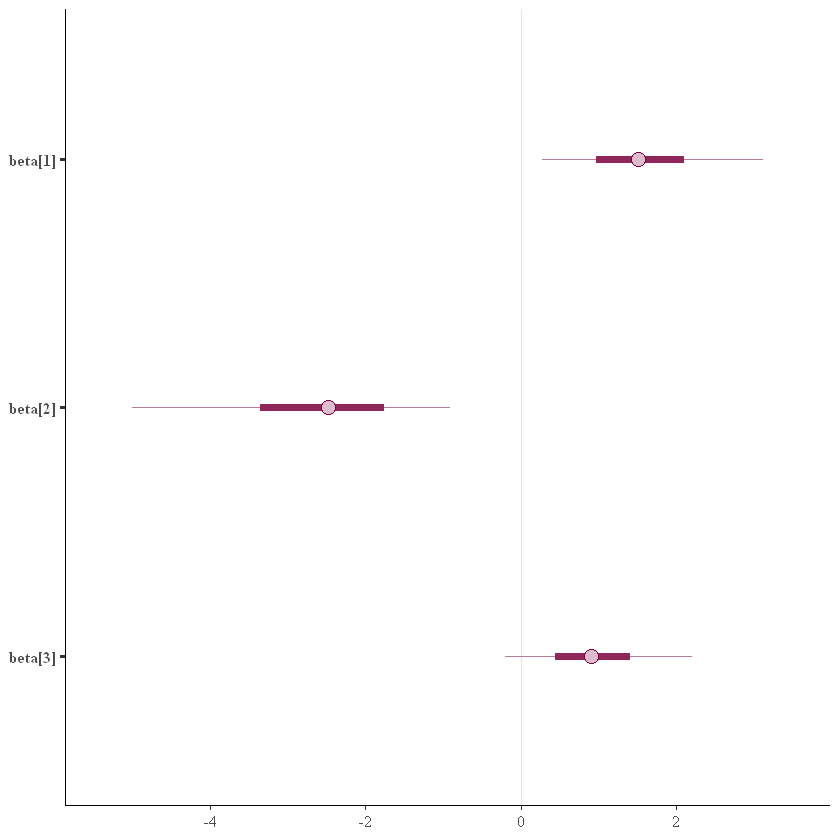

In [218]:
mcmc_intervals(result_list)

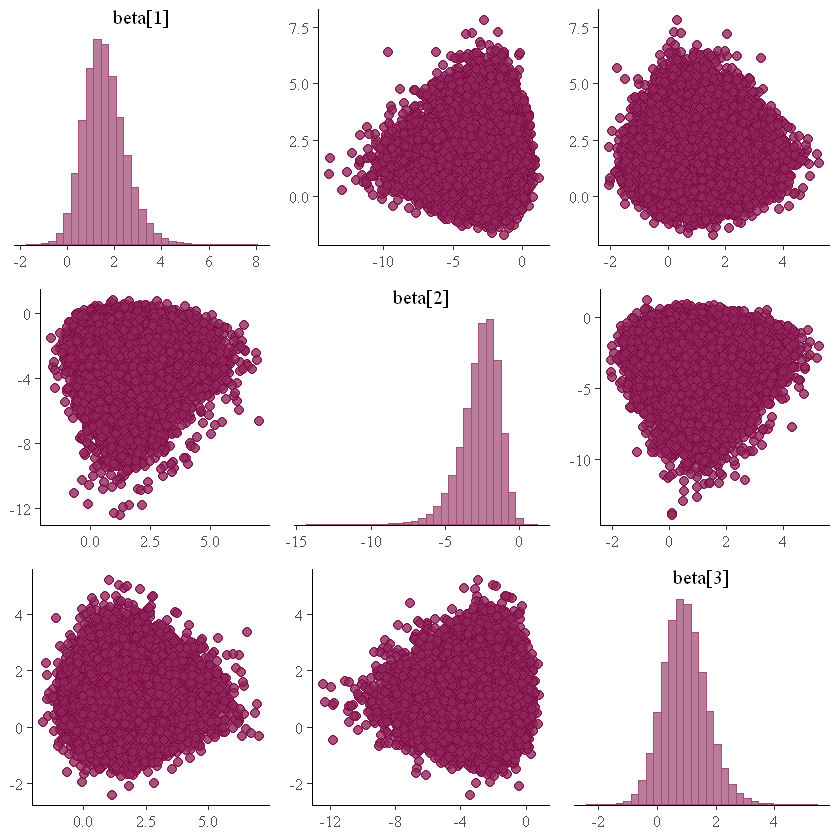

In [160]:
mcmc_pairs(result_list)

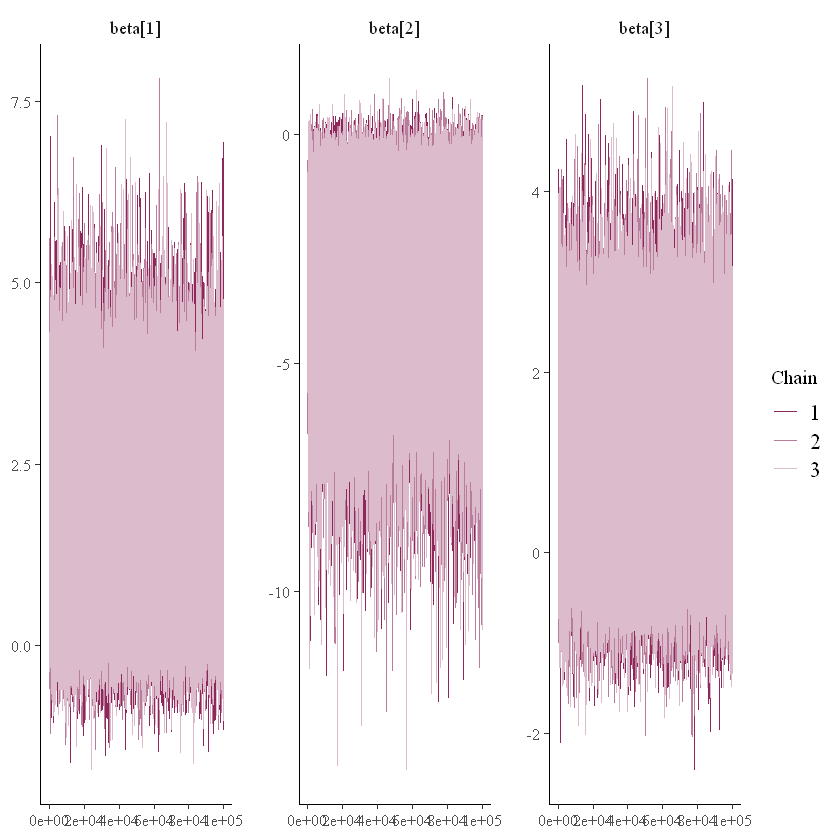

In [161]:
mcmc_trace(result_list)

In [215]:
utility <- as.matrix(dplyr::distinct(candy, Choice, .keep_all = TRUE)[5:7]) %*% as.vector(summary(output)$statistics[,1])

In [216]:
prob_choice <- exp(utility)/sum(exp(utility))

### Probabilities of choices
Check the probabilities for each choice. Candy 6 is the most probable selected by customers following by c5.

In [217]:
df_prob <- data.frame("choice" = dplyr::distinct(candy, Choice), dplyr::distinct(candy, Choice, .keep_all = TRUE)[5:7], format(prob_choice, digits=2))
colnames(df_prob) <- c("choice", "dark", "soft", "nuts", "prob_choice")
df_prob

choice,dark,soft,nuts,prob_choice
<fct>,<int>,<int>,<int>,<fct>
c1,0,0,0,0.0448
c2,0,0,1,0.1151
c3,0,1,0,0.0031
c4,0,1,1,0.0081
c5,1,0,0,0.2170
c6,1,0,1,0.5578
c7,1,1,0,0.0152
c8,1,1,1,0.0390
